# Physical model for a wound twisted deep piano string
The following code models the wound string as equivalent bar by utilising a discrete version cosserat rod theory.
While other models of strings as equivalent bars may yield similar results for straight bars under axial tension, the benefit of using cosserat rod theory speicifically, lies in its ability to elegenatly model bars that are anisotropic or have intrinsic twist – such as the twist historically often added to deep piano strings during the installation process.

In [2]:
%matplotlib inline
from py_wgpu_fdm import Simulation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from datetime import datetime
from scipy.spatial.transform import Rotation as R

## Material and geometry properties

|property|description|
|--------|-----------|
|`tuned_length`| The length of the tensioned string|
|`tension_force`| The forcing axially pulling on the string to tension it|
|`core_radius`| The radius of the core at the core of the string| 
|`winding_radius`| The radius of the wire used for the winding|
|`E_core`| The Young's modulus of the core material|
|`G_core`| The shear modulus of the core material|
|`rho_core`| The density of the core material|
|`E_winding`| The Young's modulus of the winding material|
|`G_winding`| The shear modulus of the winding material|
|`rho_winding`| The density of the winding material|
|`packing_factor`| Describes how efficiently the winding helix is covering the string|
|`mu`| The factor $\mu$ quantifies how much the winding contributes to the stiffness of the string|
|`twists`| How many twists/turns the string has post-installation (this is usually an integer)|

The `rest_length` of the string can later be determined from the stretching-stiffness $EA$ and its `tuned_length`.

In [3]:
tuned_length = 1.22 # unit: m
tension_force = 600 # unit: N
core_radius = 6.0e-4 # unit: m
winding_radius = 4.0e-4 # unit: m
E_core = 2.07e11 # unit: Pa
G_core = 8.0e10 # unit: Pa
rho_core = 7.85e3 # unit: kg/m^3
E_winding = 1.1e11 # unit: Pa
G_winding = 4.1e10 # unit: Pa
rho_winding = 8.96e3 # unit: kg/m^3
packing_factor = 0.8 # unit: 1
mu = 0.15 # unit: 1
twists = 0.0 # unit: 1

### Nodes

Discrete implementations of cosserat rod theory describe the rod's centerline as a set of discrete nodes.
Here the rod orientation is chosen, such that for a undeformed, straight rod the centerline aligns with the x axis.
The rod is discretized by `node_count` nodes.

**NB:** When choosing this spatial discretisation a common issue is that – due to the way floating point number work – most segment lenghts cannot be represented accurately. This will result in small inaccuarcies that the model interprets as intrinsic axial strain. 
However for sufficiently small spatial/time discretisations this error should be neglible.

In [4]:
node_count = 81 # unit: 1

### Edges

The nodes are connected by `node_count - 1` edges. These edges are used to represent the orientation of the material frame. 
Each orientation is represented by a unit quaternion such that applying quaternion multiplication to the the lab basis vectors $\vec{e}_1,\vec{e}_2,\vec{e}_3$ gives the director basis vectors $\vec{d}_1,\vec{d}_2,\vec{d}_3$ in lab coordinates. Similar to DER the "holonomy" corresponds to the torsion, i.e. twisting of the string. Here the widespread convention is adopted where $\vec{d}_3$ is parallel to the tangent vector of the centerline if there is no shear. It is pivotal that applying rotation by $q$ aligns the direction of $\vec{d}_3$ and $\vec{e_1}$ in this case! Otherwise there will be immense axial stress.

**NB:** WGSL stores quaternions as `(x,y,z,w)` where w is the scalar part.

With these quantities defined, the discrete representation of the string can be generated.

In [5]:
def generate_straight_rod(
    tuned_length,
    tension_force,
    node_count,
    core_radius,
    winding_radius,
    E_core,
    G_core,
    rho_core,
    E_winding,
    G_winding,
    rho_winding,
    packing_factor,
    mu,
    twists,
):


    # Mass and Inertia
    # ----------------
    
    core_area = np.pi * core_radius**2
    A = core_area
    EA = E_core * A
    dilatation = tension_force / EA
    rest_length = tuned_length / (1 + dilatation)
    dl = rest_length / float(node_count - 1)
    
    core_mass = float(rho_core * core_area * dl)
    

    winding_area = np.pi * ( (core_radius + 2.0 * winding_radius)**2 - core_radius**2 )
    winding_mass = float(rho_winding * winding_area * dl * packing_factor)

    mass = core_mass + winding_mass

    # For circular cross sections
    # This is "lumped inertia", i.e. rho * dl * I
    I_core = rho_core * core_radius**4 / 4.0 
    I_winding = rho_winding * ((core_radius + 2.0 * winding_radius)**4 - core_radius**4) * packing_factor / 4.0 
    
    I1 = I_core + I_winding
    I3 = I1 * 2.0
    inertia = ( np.pi * dl * np.array([I1, I1, I3], dtype=np.float32))

    # Shear-Stretch and Bending-Twist stiffness (diagonal)
    # ----------------------------------------------------
    

    
    alpha = 4.0 / 3.0 # Shear correction factor for circular cross sections

    I_c = np.pi * core_radius**4 / 4.0
    J = np.pi * core_radius**4 / 2.0

    I_w = ((core_radius + 2.0 * winding_radius)**4 - core_radius**4) * packing_factor / 4.0 

    EI = E_core * I_c + (E_winding * I_w * mu)
    
    # Shear along 1,2; axial along tangent (3)
    K_se = np.array([G_core * A * alpha, G_core * A * alpha, E_core * A], dtype=np.float32)

    # Bending about 1,2; torsion about tangent (3)
    K_bt = np.array([EI, EI, G_core * J], dtype=np.float32)


    # Geometry
    # --------
    
    x = np.linspace(0.0, tuned_length, node_count)
    positions = np.stack([
        x,
        np.zeros_like(x),
        np.zeros_like(x),
    ], axis=1).astype(np.float32)

    nodes = [(pos, np.zeros(3, dtype=np.float32)) for pos in positions]


    # Edges
    # -----

    angle = np.pi / 2
    half_angle = 0.5 * angle
    q_base = np.array([0.0, np.sin(half_angle), 0.0, np.cos(half_angle)])
    
    def twist_quaternion(angle):
        half = 0.5 * angle
        return np.array([
            np.sin(half),
            0.0,         
            0.0,          
            np.cos(half)  
        ])

    
    
    def quat_mul(q1, q2):
        x1, y1, z1, w1 = q1
        x2, y2, z2, w2 = q2
    
        return np.array([
            w1*x2 + x1*w2 + y1*z2 - z1*y2,
            w1*y2 - x1*z2 + y1*w2 + z1*x2,
            w1*z2 + x1*y2 - y1*x2 + z1*w2,
            w1*w2 - x1*x2 - y1*y2 - z1*z2
        ])

    def normalize_quat(q):
        return q / np.linalg.norm(q)

    total_edges = node_count - 1
    total_angle = 2.0 * np.pi * twists
    
    orientations = []
    
    for i in range(total_edges):
        angle = total_angle * (i / total_edges)
        q_twist = twist_quaternion(angle)
    
        q = normalize_quat(quat_mul(q_twist, q_base))
        orientations.append(q)

    edges = [ (o, np.zeros(3, dtype=np.float32)) for o in orientations ]
    # Ghost edge: matching the orientation of the last real segment (doesn't matter, purely for internal indexing simplification)
    edges.append((edges[-1][0], np.zeros(3, dtype=np.float32)))

    print(f'Generated straight rod with a tuned length of {tuned_length}. At rest the length would be {rest_length}') 

    return nodes, edges, dl, mass, inertia, K_se, K_bt


In [6]:
nodes, edges, dl, mass, inertia, K_se, K_bt = generate_straight_rod(
    tuned_length,
    tension_force,
    node_count,
    core_radius,
    winding_radius,
    E_core,
    G_core,
    rho_core,
    E_winding,
    G_winding,
    rho_winding,
    packing_factor,
    mu,
    twists
)

Generated straight rod with a tuned length of 1.22. At rest the length would be 1.2168812774482791


#### Sanity check: Plot intial string configuration

In [7]:
def plot_string(nodes, show_nodes=True):
    """
    nodes: Vec<[[x,y,z], [vx,vy,vz]]>
    """

    positions = np.array([n[0] for n in nodes])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Rod centerline",
    )

    # Plot nodes
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Axis labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_title("Discretized String")
    ax.legend()

    max_range = (
        np.array([
            positions[:, 0].max() - positions[:, 0].min(),
            positions[:, 1].max() - positions[:, 1].min(),
            positions[:, 2].max() - positions[:, 2].min(),
        ]).max() / 2.0
    )

    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    plt.tight_layout()
    plt.show()

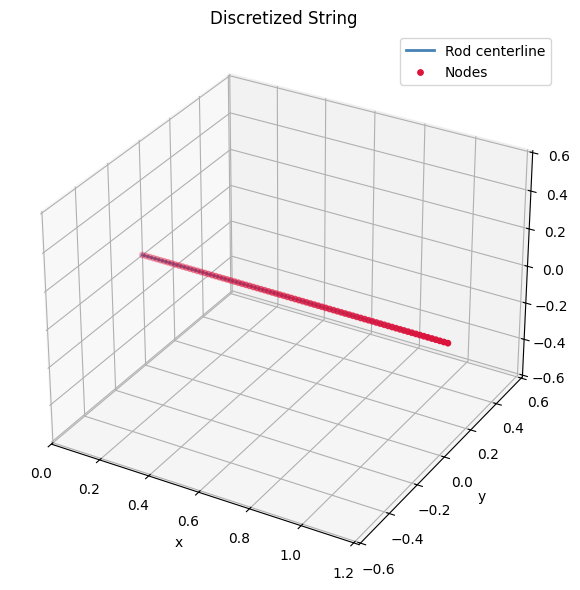

In [8]:
plot_string(nodes)

#### Sanity check: Plot quaternion orientations as axis/angle representation

Specifically *Rotated Z-axis* must sit on $(1,0,0)$ for all twists!

In [9]:
def plot_edge_quaternions(edges):
    quaternions = [ e[0] for e in edges ]

    quats = np.array(quaternions)
    norms = np.linalg.norm(quats, axis=1)
    
    plt.figure(figsize=(6,3))
    plt.plot(norms, 'o-', label='Quaternion norm')
    plt.axhline(1.0, linestyle='--', label='Unit length')
    plt.xlabel('Quaternion index')
    plt.ylabel('Norm')
    plt.title('Quaternion Norm Check')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    def rotate_vector_by_quat(v, q):
        """Rotate vector v by quaternion q (x, y, z, w)"""
        x, y, z, w = q
        q_vec = np.array([x, y, z])
        return v + 2*np.cross(q_vec, np.cross(q_vec, v) + w*v)
    
    lab_axes = np.eye(3)  # x, y, z
    endpoints = { 'x': [], 'y': [], 'z': [] }
    
    for q in quats:
        for i, axis_name in enumerate(['x','y','z']):
            rotated = rotate_vector_by_quat(lab_axes[i], q)
            endpoints[axis_name].append(rotated)
    
    # Convert to arrays
    for k in endpoints:
        endpoints[k] = np.array(endpoints[k])
    
    # --- 3D plot ---
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each axis
    ax.scatter(endpoints['x'][:,0], endpoints['x'][:,1], endpoints['x'][:,2], label='Rotated X-axis')
    ax.scatter(endpoints['y'][:,0], endpoints['y'][:,1], endpoints['y'][:,2], label='Rotated Y-axis')
    ax.scatter(endpoints['z'][:,0], endpoints['z'][:,1], endpoints['z'][:,2], label='Rotated Z-axis')
    
    # Unit sphere reference
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
    xs = np.cos(u)*np.sin(v)
    ys = np.sin(u)*np.sin(v)
    zs = np.cos(v)
    ax.plot_wireframe(xs, ys, zs, color='gray', alpha=0.2)
    
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('Quaternion Frame Visualization')
    ax.legend()
    plt.show()


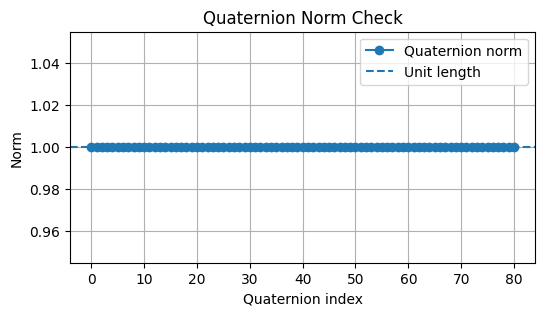

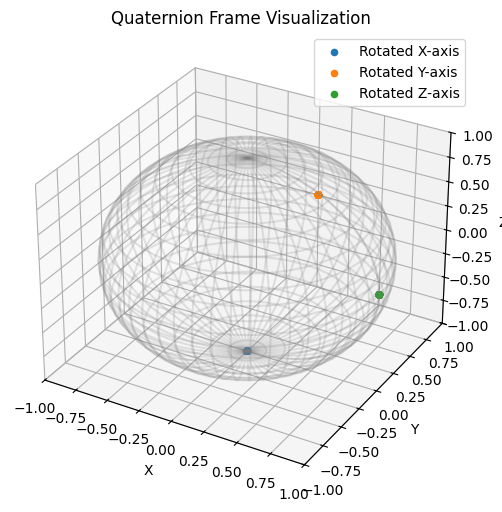

In [10]:
plot_edge_quaternions(edges)

## Time Discretization

When choosing an appropriate time-discretization it is often the case that the time-step size needed to accurately model fast moving waves (such as torsional waves in a stiff rod for example) is much smaller than what the desired `sample_rate` would demand. To aid with this, the simulation adds the `oversampling_factor` parameter. The simulation will only save the `oversampling_factor`th sample, discarding all previous ones. This process doesn't require any CPU interaction and can thus run uninhibited.

To reduce the instruction overhead caused by the memory transfer dispatches, the parmeter `chunk_size` is introduced. The simulation will keep `chunk_size` passes (frames) stored inside the GPU memory, and only trigger a transfer when the this amount is reached. 

One should bear in mind that the size of each frame depends on the amount of nodes/edges. 

In [11]:
duration = 1.0 # seconds
sample_rate = 50_000 # Hz
chunk_size = 512

dt = 2e-8 # seconds
oversampling_factor = 1.0 / (dt * sample_rate)
print(f'The appropriate oversampling factor for a target sample rate of {sample_rate} Hz at a delta t of {dt} seconds would be {oversampling_factor}.')
print(f'This yields samples that are effectively {dt * oversampling_factor} seconds apart. Therefore one chunk of {chunk_size} samples is {dt * oversampling_factor * chunk_size} seconds long.')
print(f'\nA duration of {duration} seconds would require {duration / (dt * oversampling_factor * chunk_size)} dispatches.')

if oversampling_factor.is_integer():
    oversampling_factor = int(oversampling_factor)
else:
    raise Exception("oversampling_factor must be integer value")


The appropriate oversampling factor for a target sample rate of 50000 Hz at a delta t of 2e-08 seconds would be 1000.0.
This yields samples that are effectively 2e-05 seconds apart. Therefore one chunk of 512 samples is 0.01024 seconds long.

A duration of 1.0 seconds would require 97.65624999999999 dispatches.


## Initial conditions

In this case, a small cluster of nodes near one of the string ends is given velocity into one direction. This is a rough approximation of a hammer strike, neglecting the contact time. The orientation of this impulse in the $y,z$-plane can be adjust by setting the `angle` argument to the desired rotation in radians.

In [12]:
def velocity_impulse_rotated(
    nodes: list, 
    amplitude: float, 
    sigma: float, 
    center_node_index = None,
    angle = 0.0  # rotation about X-axis in radians
):

    if center_node_index is not None:
        target_x = nodes[center_node_index][0][0] # pos.x of that node
    else:
        target_x = nodes[len(nodes) // 2][0][0]

    cos_a = np.cos(angle)
    sin_a = np.sin(angle)

    for pos, vel in nodes:
        dist = pos[0] - target_x
        dv = amplitude * np.exp(-(dist**2) / (2.0 * sigma**2))
        
        # Rotate about X-axis
        vel[2] += dv * cos_a  # Z-component
        vel[1] += dv * sin_a  # Y-component
        
    return nodes


In [13]:
nodes = velocity_impulse_rotated(nodes, 5.0, dl*4, 15, 0.0)

#### Sanity check: Plot absolute and Y/Z velocity

In [14]:
def plot_velocity_components(nodes):

    x = np.arange(len(nodes))
    
    velocities = np.array([ n[1] for n in nodes ])
    abs_velocity = np.linalg.norm(velocities, axis=1)
    
    vy = velocities[:, 1]
    vz = velocities[:, 2]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, abs_velocity, label="Absolute Velocity")
    plt.xlabel('Node X Position')
    plt.ylabel('Absolute Velocity')
    plt.title('Absolute Velocity at Each Node')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(x, vy, label="Y Component", color='r')
    plt.plot(x, vz, label="Z Component", color='b')
    plt.xlabel('Node X Position')
    plt.ylabel('Velocity Components')
    plt.title('Y and Z Velocity Components at Each Node')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


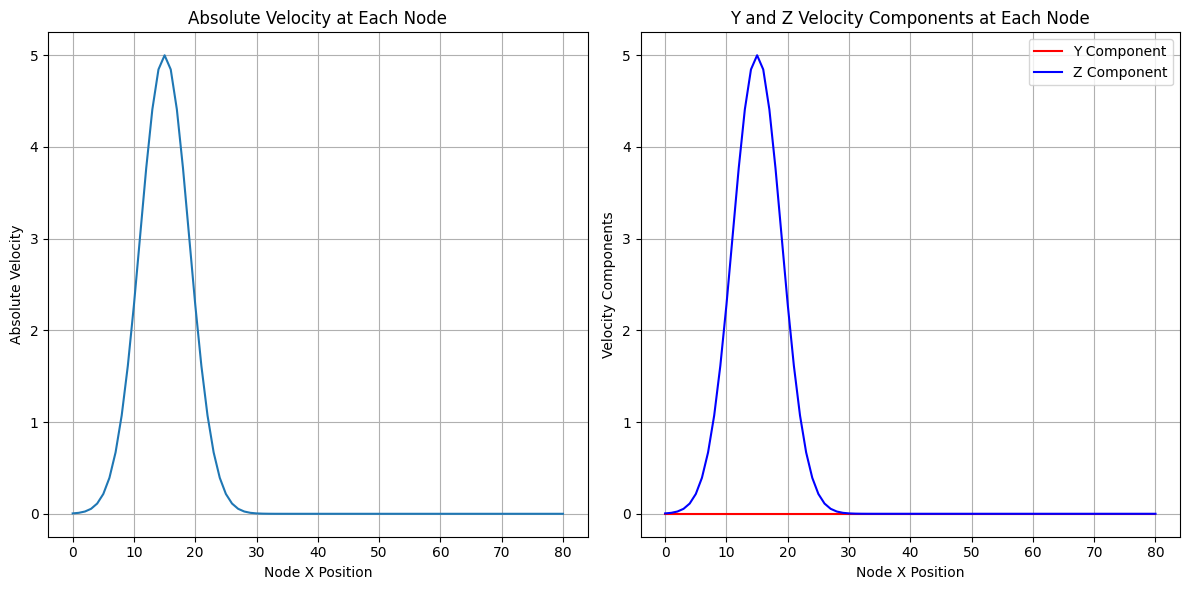

In [15]:
plot_velocity_components(nodes)

## Simulation setup

With all relevant quantities defined, the simulation instance can be initialized. The rust-side function signature is
```rust
        fn new(
            nodes: Vec<[[f32; 3]; 2]>,
            edges: Vec<([f32; 4], [f32; 3])>,
            oversampling_factor: usize,
            chunk_size: u32,
            dt: f32,
            dl: f32,
            mass: f32,
            stiffness_se: [f32; 3],
            stiffness_bt: [f32; 3],
            inertia: [f32; 3],
            clamp_offset: u32,
        ) -> PyResult<Self> {
```


In [16]:
sim = Simulation(
    nodes=nodes,
    edges=edges,
    oversampling_factor=oversampling_factor,
    chunk_size=chunk_size,
    dt=dt,
    dx=dl,
    mass=mass,
    stiffness_se = K_se,
    stiffness_bt = K_bt,
    inertia=inertia,
    clamp_offset=0
)
 

### Initializing the simulation
Calling the `initialize` method effectively generates the reference strain vectors (often $\sigma_0$ and $\kappa_0$). 
The parameters are rudimentary and do nothing.

In [17]:
sim.initialize(0.0, 1)

Initializing simulation!


### Running the simulation
`node_frames` and `edge_frames` will be used to collect the respective frame data. 
To run the simulation, first the `compute` method is called, which runs `chunk_size * oversampling_factor` simulation loops.

Then the `save` method facilitates the transfer to the CPU staging buffer, eventually making the data available to python.

In [18]:
%%time

node_frames = list()
edge_frames = list()

for i in range(100):
    sim.compute()
    n, e = sim.save()
    node_frames.extend(n)
    edge_frames.extend(e)

CPU times: user 6h 9min 3s, sys: 2h 21min 48s, total: 8h 30min 51s
Wall time: 5h 27min 56s


#### Sanity check: Are any displacements NaN?
Checking the last frame is sufficient.

In [19]:
if any(np.isnan(node[0]).any() for node in node_frames[-1]):
    print("Some displacements are NaN; the dt is likely too small for the chosen dl!")
else:
    print("No NaNs found!")


No NaNs found!


#### Sanity check: Plot string displacements
This is probably not too exciting since the expected displacement are most likely very small. However this plot can make it easy to spot if the rod isn't oscillating around its minimal energy configuration.

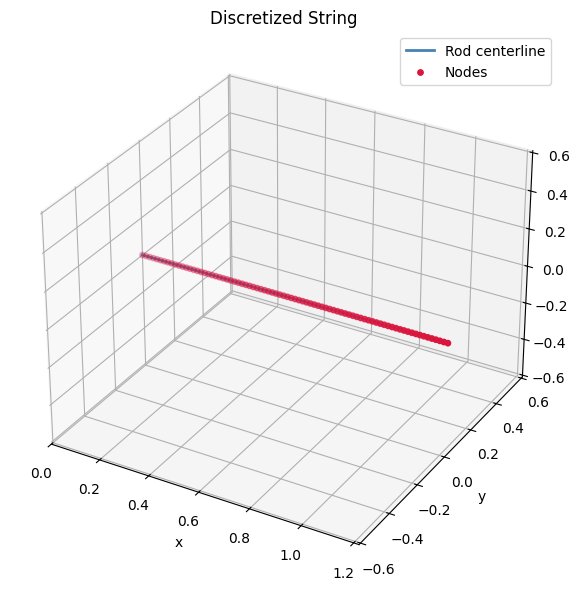

In [20]:
plot_string(node_frames[-1])

## Results

### Displacement over time & FFTs
To get a sense for the oscillations happening inside the string, as well as the frequency spectra, plots are created to visualtion the evolution of the different displacement directions. These signals are then Fourier-Transformed.

In [21]:
def plot_node_pos_vel_moment_fft(
    nodes_history,
    nodes0,
    dt,
    oversampling_factor,
    cutoff = 20_000,
    node_index = None,
    moments = False,
    save_output = False,
    windowing = False,
):

    T = len(nodes_history)
    N = len(nodes_history[0])

    if node_index is None:
        node_index = N // 2

    time = np.arange(T) * dt * oversampling_factor
    freqs = np.fft.rfftfreq(T, dt * oversampling_factor)

    pos0, _ = nodes0[node_index] # Rest position

    pos = np.zeros((T, 3), dtype=np.float32)
    vel = np.zeros((T, 3), dtype=np.float32)
    mom = np.zeros((T, 3), dtype=np.float32)

    for t in range(T):
        p, v, m, _ = nodes_history[t][node_index]
        pos[t] = p - pos0
        vel[t] = v
        mom[t] = m

    pos_mag = np.linalg.norm(pos, axis=1)
    vel_mag = np.linalg.norm(vel, axis=1)
    mom_mag = np.linalg.norm(mom, axis=1)

    components = [
        ("x", pos[:, 0], vel[:, 0], mom[:, 0]),
        ("y", pos[:, 1], vel[:, 1], mom[:, 1]),
        ("z", pos[:, 2], vel[:, 2], mom[:, 2]),
    ]

    def fft_mag(signal):
        sig = signal - np.mean(signal)

        if windowing:
            window = np.hanning(len(sig))
            sig = sig * window

        fft = np.fft.rfft(sig)
        return np.abs(fft)

    for label, p_data, v_data, m_data in components:

        n_plots = 2 + int(moments)
        fig, axes = plt.subplots(
            n_plots, 1,
            figsize=(10, 2.8 * n_plots),
            sharex=False,
        )

        if n_plots == 1:
            axes = [axes]

        ax = axes[0]

        p_max = np.max(np.abs(p_data))
        v_max = np.max(np.abs(v_data))

        p_scaled = p_data / p_max if p_max > 0 else p_data
        v_scaled = v_data / v_max if v_max > 0 else v_data

        ax.plot(time, p_scaled, color="tab:blue")
        ax.set_ylim(-1.05, 1.05)
        ax.set_ylabel(f"{label} disp", color="tab:blue")
        ax.tick_params(axis="y", labelcolor="tab:blue")
        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([f"{-p_max:.3e}", "0", f"{p_max:.3e}"])

        ax2 = ax.twinx()
        ax2.plot(time, v_scaled, "--", color="tab:orange")
        ax2.set_ylim(-1.05, 1.05)
        ax2.set_ylabel(f"{label} vel", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        ax2.set_yticks([-1, 0, 1])
        ax2.set_yticklabels([f"{-v_max:.3e}", "0", f"{v_max:.3e}"])

        ax.set_title(f"{label} — displacement & velocity (time)")
        ax.grid(True, alpha=0.3)

        plot_idx = 1
        if moments:
            axm = axes[plot_idx]

            m_max = np.max(np.abs(m_data))
            m_scaled = m_data / m_max if m_max > 0 else m_data

            axm.plot(time, m_scaled, color="tab:green")
            axm.set_ylim(-1.05, 1.05)
            axm.set_ylabel(f"{label} moment")
            axm.set_yticks([-1, 0, 1])
            axm.set_yticklabels([f"{-m_max:.3e}", "0", f"{m_max:.3e}"])
            axm.set_title(f"{label} — moment (time)")
            axm.grid(True, alpha=0.3)

            plot_idx += 1

        bins = fft_mag(p_data)
        idx = np.argmax(bins[1:]) + 1

        largest_component = freqs[idx]
        print(f'{label} FFT max frequency at {largest_component}')

        axf = axes[plot_idx]
        axf.plot(freqs, bins, color="tab:blue")
        axf.set_ylabel("FFT |disp|")
        axf.set_xlabel("Frequency [Hz]")
        axf.set_title(f"{label} — displacement FFT")

        axf.set_xlim(0, cutoff)
        axf.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_output:
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            filename = f"{timestamp}.png"
            plt.savefig(filename, dpi=300, bbox_inches="tight")

        plt.show()


x FFT max frequency at 0.9765625


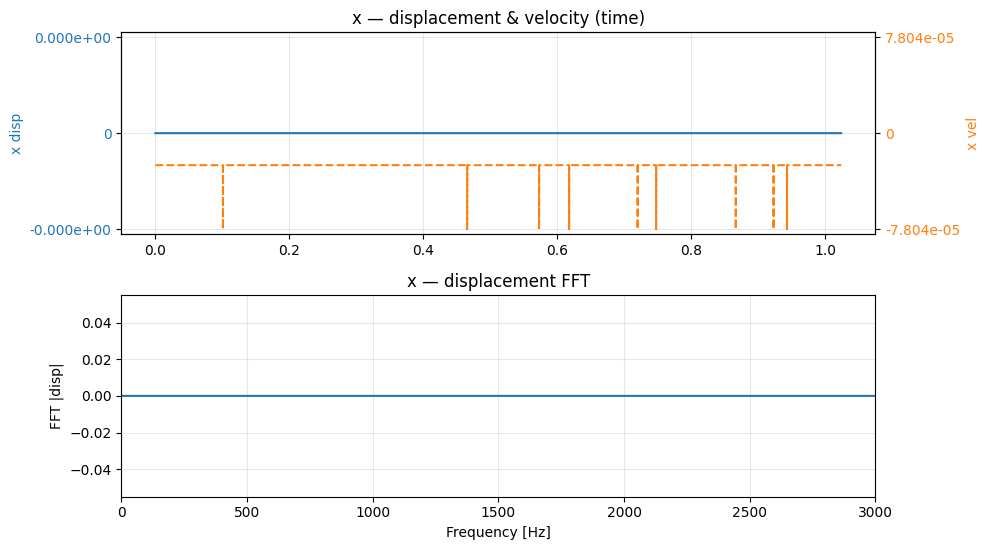

y FFT max frequency at 0.9765625


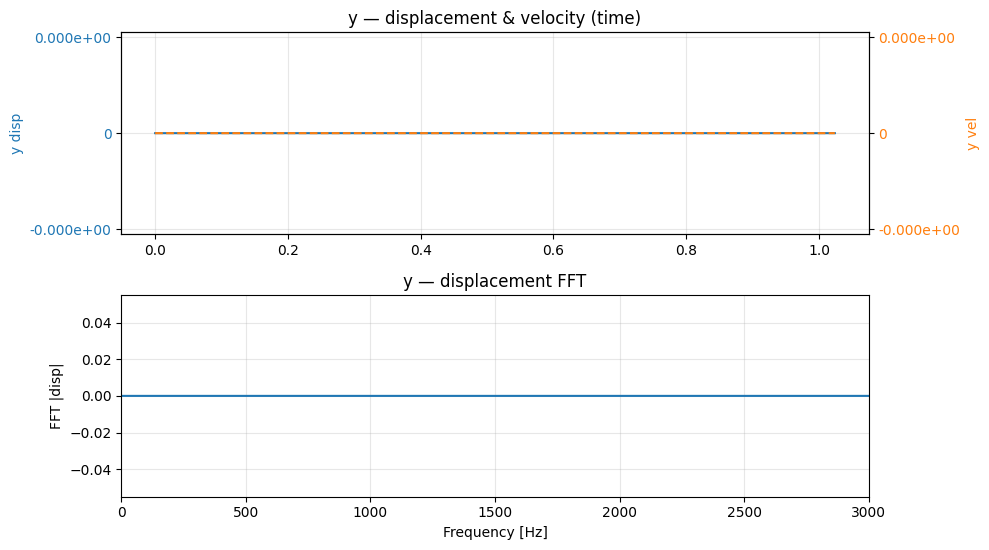

z FFT max frequency at 0.9765625


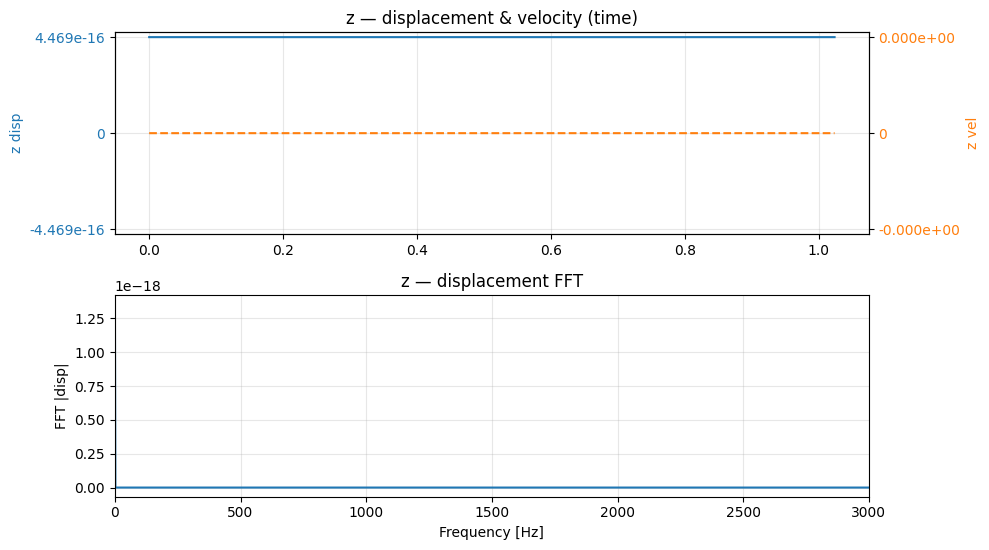

In [22]:
plot_node_pos_vel_moment_fft(node_frames, nodes, dt, oversampling_factor, cutoff=3000, windowing=True)

### Materialframe orientations

The material frame orientations are represented by unit quaternions, which aren't especially intuitive. Hence, they are transformed to an axis/angle representation to offer a slightly more intuitive visualization of rotation. In some cases disregarding one of the axis components (because it is virtually unmoved) can lead to a more insteresting plot. 

In [23]:

def plot_axis_angle_over_time(frames, node_index, components="xyz"):
    axes = []
    angles = []

    for frame_idx, frame in enumerate(frames):
        if node_index >= len(frame):
            raise IndexError(f"Node index {node_index} out of range in frame {frame_idx}")

        quat = np.array(frame[node_index][0], dtype=float)

        quat /= np.linalg.norm(quat)

        rot = R.from_quat(quat)  # (x, y, z, w)

        rotvec = rot.as_rotvec()

        angle = np.linalg.norm(rotvec)

        if angle > 1e-8:
            axis = rotvec / angle
        else:
            axis = np.array([0.0, 0.0, 0.0])

        axes.append(axis)
        angles.append(angle)

    axes = np.array(axes)
    angles = np.array(angles)

    t = np.arange(len(frames))

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

    ax1.plot(t, np.degrees(angles))
    ax1.set_ylabel("Angle (degrees)")
    ax1.set_title(f"Axis–Angle orientation over time (node {node_index})")
    ax1.grid(True)

    if 'x' in components: ax2.plot(t, axes[:, 0], label="Axis X")
    if 'y' in components: ax2.plot(t, axes[:, 1], label="Axis Y")
    if 'z' in components: ax2.plot(t, axes[:, 2], label="Axis Z")
    ax2.set_xlabel("Frame")
    ax2.set_ylabel("Axis component")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.tight_layout()
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{timestamp}_angles.png"

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


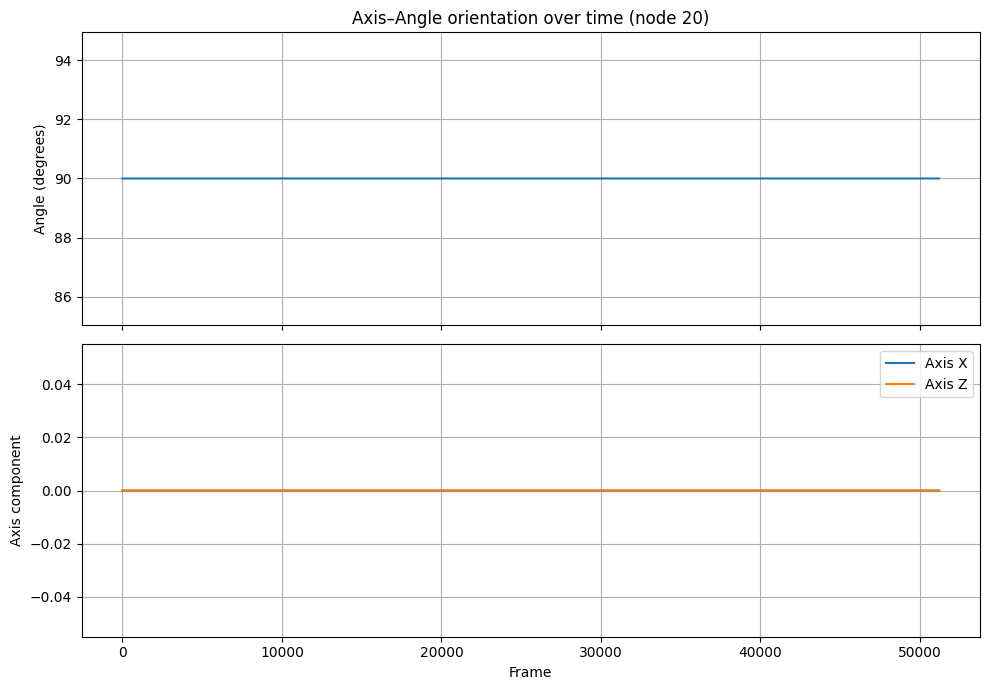

In [24]:
plot_axis_angle_over_time(edge_frames, node_index=20, components="xz")

### Energies

It may also be insightful to watch how the energy distribution of the system evolves over time. In general the system can show two kinds of kinetic energies (rotational and translation) and two kinds of potential energies (bend/twist and shear/stretch). If the string is tensioned a substantial amount of potential energy in innately present in the system. To condense the plot and more accurately display energy-exchange the parameter `remove_offset` will subtract the initial potential energy from the history. 

**NB:** to accurate remove the potential energy caused by tension one needs to simulate the system at rest and subtract those values. The `remove_offset` parameter is solely used to build intuition.

In [25]:
def E_T(node, mass):
    """Translational Kinetic Energy: 0.5 * m * v^2"""
    velocity = np.array(node[1])
    return 0.5 * mass * (velocity @ velocity)

def E_R(omega_vec, inertia):
    """Rotational Kinetic Energy: 0.5 * omega^T * I * omega"""
    w = np.array(omega_vec)
    I = np.array(inertia)
    if I.ndim == 1: I = np.diag(I)
    return 0.5 * np.dot(w, np.dot(I, w))

def E_PB(moment, kappa):
    """Bending/Twisting Potential Energy: 0.5 * kappa^T * Moment"""
    return 0.5 * np.dot(np.array(kappa), np.array(moment))

def E_PS(strain, K_se):
    """Shear/Stretch Potential Energy: 0.5 * strain^T * (K_se * strain)"""
    s = np.array(strain)
    k = np.array(K_se)
    return 0.5 * np.dot(s, k * s)
    
def E_PPS(strain, K_se):
    """Pure shear: 0.5 * strain^T * (K_se * strain)"""
    s = np.array(strain[:2])
    k = np.array(K_se[:2])
    return 0.5 * np.dot(s, k * s)


def plot_energies(nodes_frames, edges_frames, m_node, inertia, K_se, remove_offset=False, save_output=False):
    trans_ke = []
    rot_ke = []
    bend_twist_pe = []
    shear_stretch_pe = []
    pure_shear_pre = []
    
    for i in range(len(nodes_frames)):
        t_sum = 0
        bt_sum = 0
        for node in nodes_frames[i]:
            t_sum += E_T(node, m_node)
            bt_sum += E_PB(node[2], node[3]) * dl
            
        trans_ke.append(t_sum)
        bend_twist_pe.append(bt_sum)
        
        r_sum = 0
        ss_sum = 0
        ps_sum = 0
        for edge in edges_frames[i]:
            r_sum += E_R(edge[1][0], inertia)
            ss_sum += E_PS(edge[1][2], K_se) * dl
            ps_sum += E_PPS(edge[1][2], K_se) * dl

        rot_ke.append(r_sum)
        shear_stretch_pe.append(ss_sum)
    
    trans_ke = np.array(trans_ke)
    rot_ke = np.array(rot_ke)
    bend_pe = np.array(bend_twist_pe)
    shear_pe = np.array(shear_stretch_pe)

    total_kin = trans_ke + rot_ke
    total_pot = bend_pe + shear_pe

    if remove_offset:
        total_pot = total_pot - total_pot[0]
        bend_pe = bend_pe - bend_pe[0]
        shear_pe = shear_pe - shear_pe[0]

    total_energy = total_kin + total_pot

    plt.figure(figsize=(12, 8))
    
    plt.plot(trans_ke, label="Translational KE", alpha=0.4, linestyle=':')
    plt.plot(rot_ke, label="Rotational KE (Edges)", alpha=0.4, linestyle=':')
    plt.plot(bend_pe, label="Potential: Bend/Twist (Nodes)", alpha=0.4, linestyle=':')
    plt.plot(shear_pe, label="Potential: Shear/Stretch (Edges)", alpha=0.4, linestyle=':')
    plt.plot(shear_pe, label="Potential: Purely Shear (Edges)", linestyle='--')

    plt.plot(total_kin, label="TOTAL Kinetic Energy", linewidth=2, color='blue')
    plt.plot(total_pot, label="TOTAL Potential Energy", linewidth=2, color='orange')
    plt.plot(total_energy, label="TOTAL SYSTEM ENERGY", color='black', linestyle='--', linewidth=1.5)
    
    plt.title("Cosserat Rod Energy Breakdown (Total vs Components)")
    plt.ylabel("Energy (Joules)")
    plt.xlabel("Frame Index")
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_output:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"{timestamp}_energy.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        
    plt.show()

    print(f"Total Energy Mean: {np.mean(total_energy):.6e} J")
    print(f"Energy Variation: {np.std(total_energy):.6e} J")


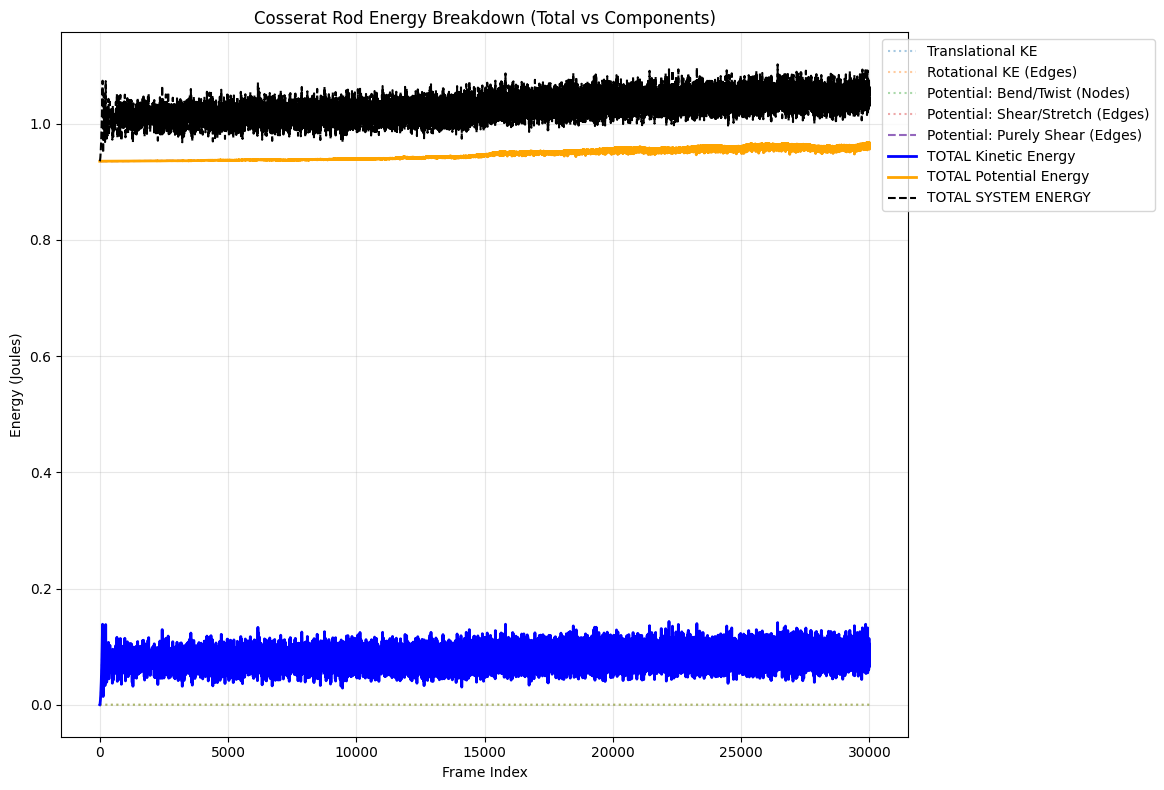

Total Energy Mean: 1.027582e+00 J
Energy Variation: 1.989502e-02 J


In [26]:
start, end = 0, 30000
plot_energies(node_frames[start:end], edge_frames[start:end], mass, inertia, K_se, remove_offset=False)

## Adding twist
By having set up a solid set of tools for simulation and visualisation, the string can easily be simulated again but this time two twists are added to replicate common real-world installation setups. Just as before we set up and initialize the simulation and run it

In [27]:
nodes, edges, dl, mass, inertia, K_se, K_bt = generate_straight_rod(
    tuned_length,
    tension_force,
    node_count,
    core_radius,
    winding_radius,
    E_core,
    G_core,
    rho_core,
    E_winding,
    G_winding,
    rho_winding,
    packing_factor,
    mu,
    twists=3.0
)
nodes = velocity_impulse_rotated(nodes, 5.0, dl*4, 15, 0.0)

Generated straight rod with a tuned length of 1.22. At rest the length would be 1.2168812774482791


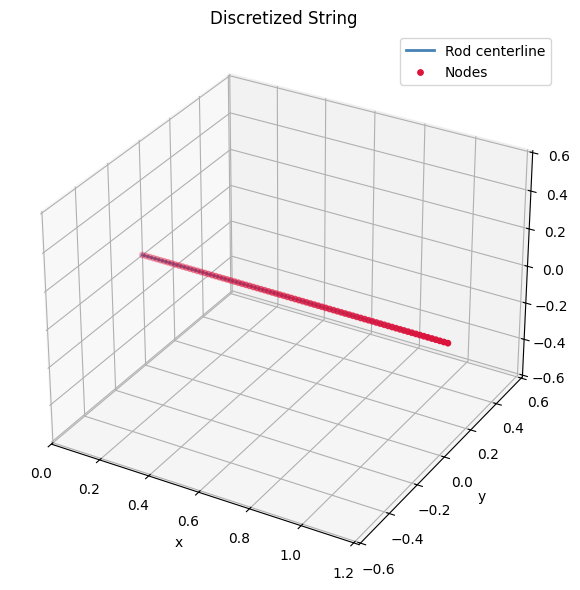

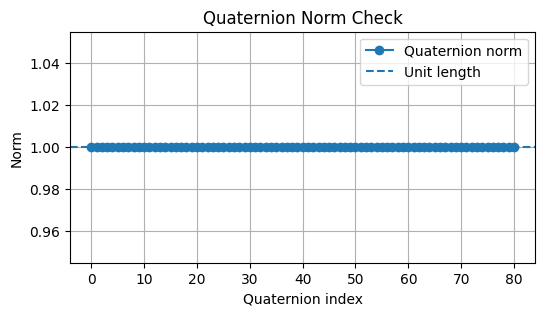

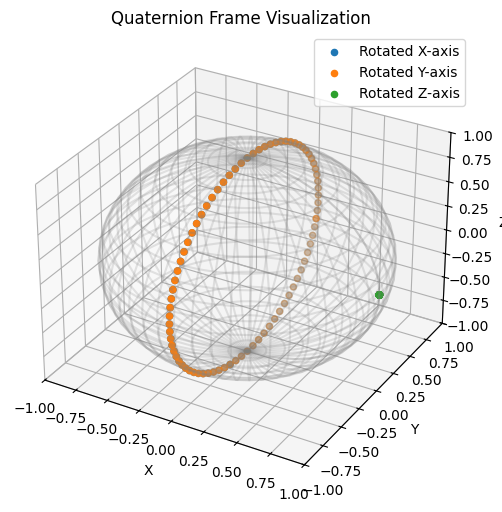

In [28]:
plot_string(nodes)
plot_edge_quaternions(edges)

In [29]:
sim = Simulation(
    nodes=nodes,
    edges=edges,
    oversampling_factor=oversampling_factor,
    chunk_size=chunk_size,
    dt=dt,
    dx=dl,
    mass=mass,
    stiffness_se = K_se,
    stiffness_bt = K_bt,
    inertia=inertia,
    clamp_offset=0
)
 

sim.initialize(0.0, 1)

Initializing simulation!


In [ ]:
%%time

node_frames = list()
edge_frames = list()

for i in range(100):
    sim.compute()
    n, e = sim.save()
    node_frames.extend(n)
    edge_frames.extend(e)

#### Sanity checks

In [ ]:
if any(np.isnan(node[0]).any() for node in node_frames[-1]):
    print("Some displacements are NaN; the dt is likely too small for the chosen dl!")
else:
    print("No NaNs found!")
    plot_string(node_frames[-1])



Using the functions from above, results are visualized.

In [ ]:
plot_node_pos_vel_moment_fft(node_frames, nodes, dt, oversampling_factor, cutoff=4000, windowing=True)

In [ ]:
plot_axis_angle_over_time(edge_frames, node_index=40, components="xyz")

In [ ]:
start, end = 0, 30000
plot_energies(node_frames[start:end], edge_frames[start:end], mass, inertia, K_se, remove_offset=True)

In [ ]:
import numpy as np
import sounddevice as sd
from scipy.signal import resample

def play_rod_displacement_as_audio(nodes_over_time, 
                                   component='z', 
                                   node_index=None, 
                                   sample_rate=44100):
    """
    Play a rod displacement as audio.

    Args:
        nodes_over_time : list of node snapshots over time
            each snapshot is list of tuples [(pos, vel, ...), ...]
        component : 'x', 'y', 'z', 'abs', or 'yz'
        node_index : int, which node to use; None = center node
        sample_rate : audio sample rate in Hz
    """
    # Updated map to include 'yz' validation
    allowed_components = {'x', 'y', 'z', 'abs', 'yz'}
    comp_map = {'x': 0, 'y': 1, 'z': 2}
    
    if component not in allowed_components:
        raise ValueError("component must be 'x','y','z','abs','yz'")

    node_count = len(nodes_over_time[0])
    if node_index is None:
        node_index = node_count // 2 

    # Extract displacement over time
    disp = []
    for snapshot in nodes_over_time:
        # Unpacking based on your structure: (pos, vel, ...)
        pos, _, _, _ = snapshot[node_index]
        
        if component == 'abs':
            val = np.linalg.norm(pos)
        elif component == 'yz':
            # Distance from origin in the YZ plane: sqrt(y^2 + z^2)
            val = np.hypot(pos[1], pos[2])
        else:
            val = pos[comp_map[component]]
            
        disp.append(val)
    
    disp = np.array(disp, dtype=np.float32)

    # Normalize to [-1,1] and remove DC offset
    # Note: For 'yz' or 'abs', removing the mean is crucial as 
    # distance is always positive and would create a loud pop/clip.
    disp -= disp.mean()
    max_val = np.max(np.abs(disp))
    if max_val > 0:
        disp /= max_val

    # Resample to match sample rate
    n_samples = len(disp)
    # Note: This assumes the input data length matches the intended duration.
    # If your simulation time step is different from 1/sample_rate, 
    # you may need to adjust the duration calculation.
    duration = n_samples / sample_rate
    audio = resample(disp, int(duration * sample_rate))

    # Play audio
    sd.play(audio, samplerate=sample_rate)
    sd.wait()

In [35]:
fs = 1.0 / (dt * oversampling_factor)
print(fs)
play_rod_displacement_as_audio(node_frames, component='z', sample_rate=fs)

50000.00000000001
